# Set Up Notebook

In [2]:
##########
# IMPORT #
##########

# Data processing and math
import pandas as pd
import numpy as np

# Statistics
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols, mixedlm
from statsmodels.stats.anova import AnovaRM
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Display handling
import warnings
from IPython.display import display, HTML


#################
# CONFIGURATION #
#################

# Suppress warnings
warnings.filterwarnings('ignore', category = UserWarning)
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.filterwarnings('ignore', category = ConvergenceWarning)

# Configure display
display(HTML("<style>.output_scroll { height: auto !important; max-height: none !important; }</style>"))

# Set global plotting style
sns.set_theme(style = "whitegrid")
%matplotlib inline


##########
# LABELS #
##########
labels_measure = {
    'measure_action':  'Responsibility for Action',
    'measure_beliefs': 'Responsibility for Character',
    'measure_self':    'True Self'
}

labels_gender = {
    '1': 'Female',
    '2': 'Male',
    '3': 'Non-binary',
    '4': 'Prefer not to say'
}

labels_education = {
    '1': 'Less than high school',
    '2': 'High school diploma or equivalent',
    '3': 'Associate degree (e.g., AA or AS)',
    '4': 'Bachelor’s degree (e.g., BA or BSC)',
    '5': 'Master’s degree (e.g., MA or MSc)',
    '6': 'Professional degree (e.g., JD or MD)',
    '7': 'Doctorate (e.g., PhD or EdD)'
}


#################
# VISUALIZATION #
#################
palette_main = {
    "Good": "#0072B2", "Bad": "#D55E00",
    "Reflected": "#009E73", "Unreflected": "#CC79A7",
    "Activist": "#56B4E9", "Bigot": "#E69F00",
    "Help": "#F0E442", "Harm": "#882255"
}

palette_context = ["#0072B2", "#D55E00", "#009E73"]

# Transform Data

In [3]:
# Load data
df = pd.read_csv('blame_praise_self_data_1.csv')

# Define factors
def get_factors(n):
    idx = n - 1
    upbringing = "Good" if (idx >> 3) & 1 else "Bad"
    reflection = "Reflected" if (idx >> 2) & 1 else "Unreflected"
    belief = "Bigot" if (idx >> 1) & 1 else "Activist"
    valence = "Harm" if idx & 1 else "Help"
    return upbringing, reflection, belief, valence

# Reshape wide to long
contexts = ['homophobia', 'racism', 'sexism']
measure_mapping = {'pAction': 'measure_action', 'pBeliefs': 'measure_beliefs', 'agreement': 'measure_self'}
long_data = []

for _, row in df.iterrows():
    p_id = row['ID']
    for ctx in contexts:
        for i in range(1, 17):
            col_base = f'{ctx}.{i}'
            if f'{col_base}-pAction' in df.columns and pd.notna(row[f'{col_base}-pAction']):
                up_f, refl_f, bel_f, val_f = get_factors(i)
                trial_data = {
                    'ID': p_id, 'Context': ctx, 'Upbringing': up_f, 
                    'Reflection': refl_f, 'Belief': bel_f, 'Action': val_f
                }
                for old_suffix, new_name in measure_mapping.items():
                    val = pd.to_numeric(row[f'{col_base}-{old_suffix}'], errors='coerce')
                    
                    # Center scale
                    trial_data[new_name] = val - 7 if pd.notna(val) else np.nan
                long_data.append(trial_data)

df_long = pd.DataFrame(long_data).dropna(subset=['measure_action'])

# Create DataFrames
demo_cols = ['ID', 'Gender', 'Age', 'Education', 'politics', 'determinism', 'freeWill']
df_robust = df_long.merge(df[demo_cols], on = 'ID', how = 'left')

# Rename variables
df_robust = df_robust.rename(columns={
    'politics':    'Political_Orientation', 
    'determinism': 'Social_Determinism', 
    'freeWill':    'Free_Will'
})

# Apply z-standardization of continuous covariates
covs = ['Age', 'Political_Orientation', 'Social_Determinism', 'Free_Will']

# Ensure numeric types before scaling
df_robust[covs] = df_robust[covs].apply(pd.to_numeric, errors='coerce')

# Apply z-score formula
df_robust[[f'{c}_z' for c in covs]] = df_robust[covs].apply(lambda x: (x - x.mean()) / x.std())

print(f"Transformation complete ({len(df_robust)} Observations).")

Transformation complete (1605 Observations).


# Compare Contexts

measure_action : F = 0.757, p = 0.469
measure_beliefs: F = 0.810, p = 0.445
measure_self   : F = 4.738, p = 0.009


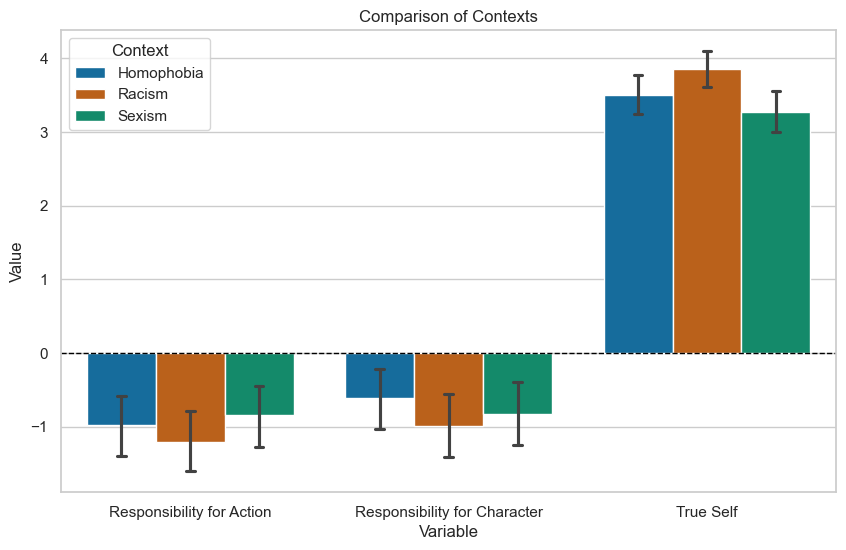

Graph saved as 'blame_praise_self_experiment_1_contexts.png'.


In [6]:
# Define measures
measures = ['measure_action', 'measure_beliefs', 'measure_self']

# Run ANOVAs
for m in measures:
    group_data = [df_long[df_long['Context'] == c][m].dropna() for c in contexts]
    f_stat, p_val = stats.f_oneway( * group_data)
    print(f"{m:15}: F = {f_stat:.3f}, p = {p_val:.3f}")

# Create graph
df_plot = df_long.rename(columns = labels_measure).melt(id_vars = 'Context', value_vars = labels_measure.values())
df_plot['Context'] = df_plot['Context'].str.capitalize()

plt.figure(figsize = (10, 6))
sns.barplot(data = df_plot,
            x = 'variable',
            y = 'value',
            hue = 'Context',
            palette = palette_context,
            capsize = .1)

# Set style
plt.axhline(0, color = 'black', ls = '--', lw = 1)
plt.title("Comparison of Contexts")
plt.xlabel("Variable")
plt.ylabel("Value")

# Export graph
filename = 'blame_praise_self_experiment_1_contexts.png'
plt.savefig(filename, dpi = 300, bbox_inches = 'tight')

plt.show()
print(f"Graph saved as '{filename}'.")

# Sociodemographics

In [ ]:
df_robust['Gender_Labeled'] = df_robust['Gender'].astype(str).map(labels_gender)
df_robust['Education_Labeled'] = df_robust['Education'].astype(str).map(labels_education)

for col in ['Gender_Labeled', 'Education_Labeled']:
    print(f"\n{col}:")
    display(df_robust[col].value_counts().to_frame('Frequency'))

# Background Variables

In [ ]:
# Define background variables
background_vars = ['Political_Orientation', 'Social_Determinism', 'Free_Will']

# Get summary
background_summary = df_robust[background_vars].describe().T[['mean', 'std', 'min', 'max']].round(3)
display(background_summary)

# Map titles to labels
background_titles = {
    'Political_Orientation': 'Political Orientation\n(1 = Liberal, 7 = Conservative)',
    'Social_Determinism':    'Social Determinism\n(1 = Low, 7 = High)',
    'Free_Will':             'Free Will\n(1 = Low, 7 = High)'
}

# Generate graphs
plt.figure(figsize = (18, 5))

for i, col in enumerate(background_vars, 1):
    plt.subplot(1, 3, i)
    sns.countplot(data = df_robust, x = col, color = 'salmon', edgecolor = 'black')
    
    # Set style
    plt.title(background_titles[col], fontweight = 'bold', pad = 15)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.ylim(0, df_robust[col].value_counts().max() * 1.1)

# Export graphs
filename = f'blame_praise_self_experiment_1_background.png'
plt.tight_layout()
plt.savefig(filename, dpi = 300)
plt.show()
print(f"Graph saved as '{filename}'.")

# Calculate Descriptive Statistics

In [ ]:
# Define group factors
group_factors = ['Upbringing', 'Reflection', 'Belief', 'Action']

# Define dependent variables
dependent_vars = ['measure_action', 'measure_beliefs', 'measure_self']

# Calculate descriptive statistics
descriptive_stats = df_long.groupby(group_factors)[dependent_vars].agg(['mean', 'std', 'count']).round(3)

# Display results
display(descriptive_stats)

# Perform ANOVAs

In [ ]:
for dv in dependent_vars:
    
    # Print headers
    print(f"\nANOVA ({labels_measure.get(dv, dv)})")
    
    # Define formula
    formula = f"{dv} ~ C(Upbringing) * C(Reflection) * C(Belief) * C(Action) * C(Context)"
    model = ols(formula, data = df_long).fit()
    
    # Run ANOVAs
    aov = sm.stats.anova_lm(model, typ = 2)
    
    # Calculate effect sizes
    aov['partial_eta_sq'] = aov['sum_sq'] / (aov['sum_sq'] + aov.loc['Residual', 'sum_sq'])
    
    # Rename columns
    aov.index.name = 'Source'
    aov = aov.rename(columns = {'sum_sq': 'SS', 'df': 'DF', 'PR(>F)': 'p-unc'})
    
    # Display results
    display(aov[['SS', 'DF', 'F', 'p-unc', 'partial_eta_sq']].round(3))

# Perform ANCOVAs

In [ ]:
# Define covariates
covariates = ["C(Gender)", "Age", "C(Education)", "Political_Orientation", "Social_Determinism", "Free_Will"]

for dv in dependent_vars:
    
    # Print header
    print(f"\nANCOVA ({labels_measure.get(dv, dv)})")
    
    # Define formula
    formula = f"{dv} ~ Upbringing * Reflection * Belief * Action + " + " + ".join(covariates)
    
    model = ols(formula, data = df_robust).fit()
    
    # Run ANCOVAs
    aov_table = sm.stats.anova_lm(model, typ = 2)
    
    # Calculate effect sizes
    res_ss = aov_table.loc['Residual', 'sum_sq']
    aov_table['partial_eta_sq'] = aov_table['sum_sq'] / (aov_table['sum_sq'] + res_ss)
    
    # Rename columns
    aov_table = aov_table.rename(columns = {'sum_sq': 'SS', 'df': 'DF', 'PR(>F)': 'p-unc'})
    
    # Display results
    display(aov_table[['SS', 'DF', 'F', 'p-unc', 'partial_eta_sq']].round(3))

# Perform Mediation Analysis

In [1]:
def run_mediation(data, x, m, y, seed = 42):
    
    # Regression M ~ X (path a)
    model_m = ols(f"{m} ~ {x}", data = data).fit()
    path_a = model_m.params[x]
    p_a = model_m.pvalues[x]

    # Regression Y ~ X + M (path b and direct effect c)
    model_y = ols(f"{y} ~ {x} + {m}", data = data).fit()
    path_b = model_y.params[m]
    p_b = model_y.pvalues[m]
    path_c_prime = model_y.params[x]
    p_c_prime = model_y.pvalues[x]

    # Indirect Effect (ab)
    indirect_effect = path_a * path_b
    
    # Create summary tables
    results = pd.DataFrame({
        'Path': ['a (X -> M)', 'b (M -> Y)', 'Direct (c\')', 'Indirect (ab)'],
        'Coefficient': [path_a, path_b, path_c_prime, indirect_effect],
        'p-value': [p_a, p_b, p_c_prime, np.nan]
    })
    return results

# Convert upbringing to binary
df_long['Upbringing_bin'] = df_long['Upbringing'].map({'Bad': 0, 'Good': 1})

# Run Mediation 1
print("\nMediation Analysis: Upbringing -> Beliefs -> Action Evaluation")
med_results_1 = run_mediation(df_long, 'Upbringing_bin', 'measure_beliefs', 'measure_action')
display(med_results_1.round(3))

# Run Mediation 2
print("\nMediation Analysis: Upbringing -> Deep Self -> Action Evaluation")
med_results_2 = run_mediation(df_long, 'Upbringing_bin', 'measure_self', 'measure_action')
display(med_results_2.round(3))

NameError: name 'df_long' is not defined

# Perform LMMs

In [ ]:
# Hide warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Create dictionary
models_base = {}

# Run LMMs
for dv in ['measure_action', 'measure_beliefs', 'measure_self']:
    lmm_formula = f"{dv} ~ Upbringing * Reflection * Belief * Action"
    
    # Save in dictionary
    models_base[dv] = mixedlm(lmm_formula, data = df_long, groups = df_long["Context"]).fit()
    
    # Print
    print(f"\n{labels_measure.get(dv, dv)}")
    print(models_base[dv].summary())

# Reset warnings
warnings.resetwarnings()

# Perform LMMs with Covariates

In [ ]:
# Hide warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Create dictionary
models_robust = {}

# Define predictors
predictors = "Upbringing * Reflection * Belief * Action"

# Define covariates
covariates = " + C(Gender) + C(Education) + Age_z + Political_Orientation_z + Social_Determinism_z + Free_Will_z"

# Define dependent variables
dependent_vars = ['measure_action', 'measure_beliefs', 'measure_self']

# Run LMMs with covariates
for dv in dependent_vars:
    full_formula = f"{dv} ~ {predictors} + {covariates}"
    
    print(f"\n{labels_measure.get(dv, dv)}")
    
    try:
        model = mixedlm(full_formula,
                        data = df_robust,
                        groups = df_robust["Context"]
                       ).fit(method = ['lbfgs'], maxiter = 2000)

        # Save in dictionary
        models_robust[dv] = model

        # Print
        print(model.summary())
    
    except Exception as e:
        print(f"Error calculating {dv}: {e}")

# Reset warnings
warnings.resetwarnings()

# Compare LMMs with and without Covariates

In [ ]:
for dv in dependent_vars:
    if dv in models_base and dv in models_robust:
        
        # Get data
        base_params = models_base[dv].params
        base_p = models_base[dv].pvalues
        robust_params = models_robust[dv].params
        robust_p = models_robust[dv].pvalues
        
        # Create DataFrame
        df_comp = pd.DataFrame({
            'Base Coef': base_params,
            'Robust Coef': robust_params,
            'Base p': base_p,
            'Robust p': robust_p
        }).loc[base_params.index]
        
        # Set titles
        title = labels_measure.get(dv, dv)
        print(f"{title}")
        
        # Display tables
        display(df_comp.round(3))

# Generate Bar Plots

In [ ]:
# Define combinations
combinations = [
    ("Upbringing", "Reflection", "Action"),
    ("Reflection", "Belief", "Action"),
    ("Upbringing", "Belief", "Action")
]

# Create graphs
for measure in dependent_vars:
    current_label = labels_measure.get(measure, measure)
    
    for x_var, hue_var, col_var in combinations:
        g = sns.catplot(data = df_long,
                        x = x_var,
                        y = measure,
                        hue = hue_var,
                        col = col_var,
                        kind = "bar",
                        capsize = .05,
                        errorbar = "ci",
                        palette = palette_main,
                        height = 5
                       )
        
        # Set style
        x_label_text = f"{x_var}"
        g.set_axis_labels(x_label_text, "Mean Score (-6 to +6)")
        g.set_titles("{col_name}")
        
        g.fig.suptitle(f"{x_var} × {hue_var} ({current_label})", y = 1.05, fontsize = 14)
        
        for ax in g.axes.flat:
            ax.axhline(0, color = 'black', linewidth = 1)
            ax.set_ylim(-6, 6)
        
        # Export graphs
        filename = f'blame_praise_self_experiment_1_bar_plot_{measure}_{x_var}_{hue_var}.png'.lower()
        g.savefig(filename, dpi = 300, bbox_inches = 'tight')
        plt.show()
        print(f"Graph saved as '{filename}'.")

# Generate Point Plots

In [ ]:
# Define interactions
interactions = [
    ("Reflection", "Belief", "Action"),
    ("Upbringing", "Belief", "Action")
]

# Iterate through dependent variables and interactions
for measure in dependent_vars:
    current_label = labels_measure.get(measure, measure)
    
    for x_var, hue_var, col_var in interactions:
        
        # Create graphs
        g = sns.catplot(data = df_long,
                        x = x_var,
                        y = measure,
                        hue = hue_var,
                        col = col_var,
                        kind = "point",
                        capsize = .15,
                        palette = palette_main,
                        height = 5,
                        aspect = 1
                       )
        
        # Set axis labels and titles
        g.set_axis_labels(x_var, f"{current_label}")
        g.set_titles("{col_name}")
        
        # Add main titles
        g.fig.suptitle(f"{x_var} × {hue_var} ({current_label})", y = 1.05, fontsize = 14)
        
        # Format axes
        for ax in g.axes.flat:
            
            # Add horizontal zero lines
            ax.axhline(0, color = 'black', linewidth = 1, linestyle = '--', alpha = 0.5)
            
            # Set scale limits
            ax.set_ylim(-6, 6)
        
        # Export graphs
        filename = f'blame_praise_self_experiment_1_interaction_plot_{measure}_{x_var}_{hue_var}.png'.lower()
        g.savefig(filename, dpi = 300, bbox_inches = 'tight')
        plt.show()
        print(f"Graph saved as '{filename}'.")

# Generate Violin Plots

In [ ]:
# Reshape DataFrame from wide to long for categorical plotting
df_melted = df_long.melt(id_vars = ['Action', 'Upbringing', 'Reflection', 'Belief', 'Context'],
                         value_vars = dependent_vars, var_name = 'Measure', value_name = 'Score')

# Map measures to labels
df_melted['Measure'] = df_melted['Measure'].replace({
    'measure_action':  'Responsibility for Action',
    'measure_beliefs': 'Responsibility for Character',
    'measure_self':    'True Self'
})

# Map factors to color palettes
dimensions = [
    ('Upbringing', palette_main),
    ('Reflection', palette_main),
    ('Action',     palette_main),
    ('Belief',     palette_main)
]

# Create graphs
for factor_name, palette in dimensions:
    plt.figure(figsize = (10, 6))
    
    # Split violins
    sns.violinplot(data = df_melted, x = "Measure", y = "Score", hue = factor_name,
                   split = True, inner = "quart", palette = palette)
    
    # Set style
    plt.axhline(0, color = 'black', linewidth = 1, linestyle = '--')
    plt.title(f"{factor_name}", fontsize = 14)
    plt.ylim(-7, 7)
    
    # Export graphs
    filename = f'blame_praise_self_experiment_1_violin_plot_{factor_name}.png'.lower()
    plt.savefig(filename, dpi = 300, bbox_inches = 'tight')
    print(f"Graph saved as '{filename}'.")